In [126]:
%matplotlib inline

In [127]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import sympy as sym

import pycollocation
import pyam

## Defining inputs

Need to define some heterogenous factors of production...

In [128]:
# define some workers skill
x, loc1, mu1, sigma1 = sym.var('x, loc1, mu1, sigma1')
skill_cdf = 0.5 + 0.5 * sym.erf((sym.log(x - loc1) - mu1) / sym.sqrt(2 * sigma1**2))
skill_params = {'loc1': -1e-1, 'mu1': 0.0, 'sigma1': 1.0}
skill_bounds = [-skill_params['loc1'], 1e2]

workers = pyam.Input(var=x,
                     cdf=skill_cdf,
                     params=skill_params,
                     bounds=skill_bounds,
                     )

# define some firms
y, loc2, mu2, sigma2 = sym.var('y, loc2, mu2, sigma2')
productivity_cdf = 0.5 + 0.5 * sym.erf((sym.log(y - loc2) - mu2) / sym.sqrt(2 * sigma2**2))
productivity_params = {'loc2': -1e-1, 'mu2': 0.0, 'sigma2': 1.0}
productivity_bounds = [-productivity_params['loc2'], 1e2]

firms = pyam.Input(var=y,
                   cdf=productivity_cdf,
                   params=productivity_params,
                   bounds=productivity_bounds,
                   )

## Defining a production process

Next need to define some production process...

In [129]:
# define symbolic expression for CES between x and y
omega_A, sigma_A = sym.var('omega_A, sigma_A')
A = ((omega_A * x**((sigma_A - 1) / sigma_A) + 
     (1 - omega_A) * y**((sigma_A - 1) / sigma_A))**(sigma_A / (sigma_A - 1))) 

# define symbolic expression for CES between x and y
r, l, omega_B, sigma_B = sym.var('r, l, omega_B, sigma_B')
B = ((omega_B * r**((sigma_B - 1) / sigma_B) + 
     (1 - omega_B) * l**((sigma_B - 1) / sigma_B))**(sigma_B / (sigma_B - 1))) 

F = A * B

In [130]:
# positive assortativity requires that sigma_A * sigma_B < 1
F_params = {'omega_A':0.25, 'omega_B':0.5, 'sigma_A':0.5, 'sigma_B':1.0}

## Define a boundary value problem

In [131]:
problem = pyam.AssortativeMatchingProblem(assortativity='positive',
                                          input1=workers,
                                          input2=firms,
                                          F=sym.limit(F, sigma_B, 1),
                                          F_params=F_params)

## Pick some collocation solver

In [132]:
solver = pycollocation.OrthogonalPolynomialSolver(problem)

## Compute some decent initial guess

In [133]:
initial_guess = pyam.OrthogonalPolynomialInitialGuess(solver)
initial_polys = initial_guess.compute_initial_guess("Chebyshev",
                                                    degrees={'mu': 175, 'theta': 175},
                                                    exp=0.5)

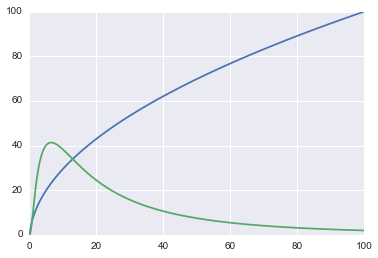

In [134]:
# quickly plot the initial conditions
xs = np.linspace(workers.lower, workers.upper, 1000)
plt.plot(xs, initial_polys['mu'](xs))
plt.plot(xs, initial_polys['theta'](xs))
plt.grid('on')

## Solve the model!

In [135]:
domain = [workers.lower, workers.upper]
initial_coefs = {'mu': initial_polys['mu'].coef,
                 'theta': initial_polys['theta'].coef}

solver.solve(kind="Chebyshev",
             coefs_dict=initial_coefs,
             domain=domain,
             method='hybr')

In [136]:
solver.result.success

True

## Plot some results

In [137]:
viz = pycollocation.Visualizer(solver)

In [138]:
np.logspace?

In [139]:
domain

[0.1, 100.0]

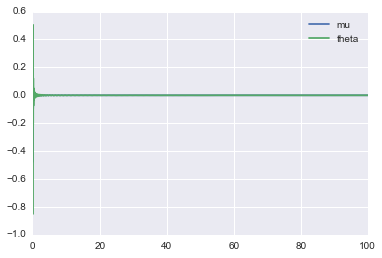

In [140]:
viz.interpolation_knots = np.logspace(-1, 2, 1000)
viz.residuals.plot()
plt.show()

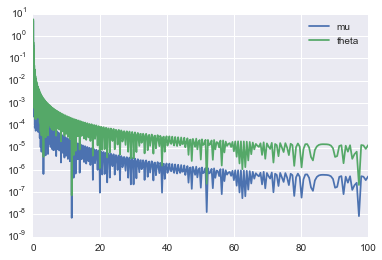

In [141]:
viz.normalized_residuals.plot(logy=True)
plt.show()

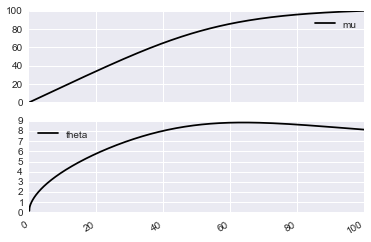

In [142]:
viz.solution.plot(subplots=True)
plt.show()

## Plot the density for firm size

Here I make use of Philipp's trick...

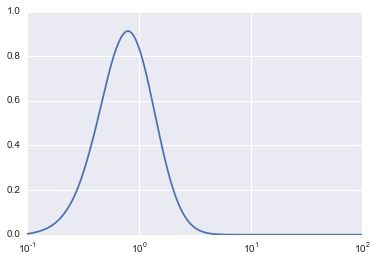

In [149]:
(viz.solution.theta * workers.evaluate_pdf(viz.solution.index.values)).plot(logx=True)
plt.show()

{'mu': array([  6.23814274e+01,   5.04851144e+01,  -1.32471710e+01,
         -6.19520521e-01,   1.09040898e+00,   3.85662679e-02,
         -1.51387920e-01,   6.19887197e-03,   1.96110606e-02,
          4.50214830e-04,  -5.82345003e-03,   3.01685344e-03,
         -1.92861952e-03,   2.25744250e-03,  -2.39264226e-03,
          2.27447025e-03,  -2.16808054e-03,   2.10353603e-03,
         -2.03939834e-03,   1.96860200e-03,  -1.89836700e-03,
          1.83081842e-03,  -1.76513815e-03,   1.70109527e-03,
         -1.63894177e-03,   1.57880871e-03,  -1.52069653e-03,
          1.46459023e-03,  -1.41047608e-03,   1.35832782e-03,
         -1.30810682e-03,   1.25976758e-03,  -1.21326050e-03,
          1.16853283e-03,  -1.12552969e-03,   1.08419498e-03,
         -1.04447213e-03,   1.00630465e-03,  -9.69636499e-04,
          9.34412392e-04,  -9.00578081e-04,   8.68080509e-04,
         -8.36867952e-04,   8.06890115e-04,  -7.78098198e-04,
          7.50444938e-04,  -7.23884632e-04,   6.98373148e-04,
  

OrderedDict([('loc1', -0.1), ('loc2', -0.1), ('mu1', 0.0), ('mu2', 0.0), ('omega_A', 0.25), ('omega_B', 0.5), ('sigma1', 1.0), ('sigma2', 1.0), ('sigma_A', 0.5), ('sigma_B', 1.0)])

OrderedDict([('loc1', -0.1), ('loc2', -0.1), ('mu1', 0.0), ('mu2', 0.0), ('omega_A', 0.25), ('omega_B', 0.5), ('sigma1', 0.5), ('sigma2', 1.0), ('sigma_A', 0.5), ('sigma_B', 1.0)])